# Variational AutoEncoders

We will implement a Variational AutoEncoder and run it on face data.

Once you are satisfied with your implementation, send hw2.ipynb to **vjojic+hw2+comp790@cs.unc.edu**.

Save your python notebook frequently.

All you have to do is replace ```...``` with appropriate code.

The deadline for this homework assignment is 4/4/2017 23:59PM EST.
$ %These are LaTeX definitions used below to save space
\newcommand{\zz}{\mathbf{z}} \newcommand{\xx}{\mathbf{x}} 
\newcommand{\hh}{\mathbf{h}} \newcommand{\bb}{\mathbf{b}}
\newcommand{\dec}{\textrm{dec}} \newcommand{\enc}{\textrm{enc}} 
\newcommand{\rec}{\textrm{rec}}
\newcommand{\relu}{\textrm{ReLU}} \newcommand{\mmu}{\boldsymbol{\mu}}
\newcommand{\ssigma}{\boldsymbol{\sigma}} \newcommand{\eepsilon}{\boldsymbol{\epsilon}}
\newcommand{\KL}{\textrm{KL}}
$

## Load data
First we will look at the data. 

Shape of data (samples x dimensions): (1965, 560)
Each row of data matrix is an image consisting of 20*28=560 pixels.
Some images from the dataset


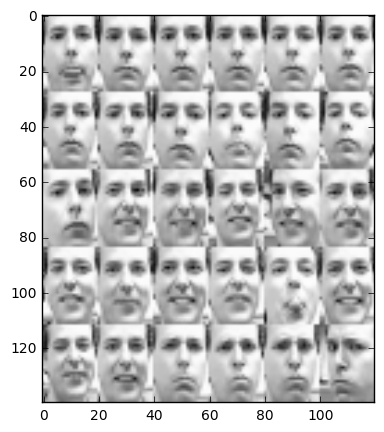

In [1]:
import numpy as np
import matplotlib.pyplot as pyplot
%matplotlib inline 
faces = np.load('freyfaces.npy',encoding='latin1')
print("Shape of data (samples x dimensions):",faces.shape)
print("Each row of data matrix is an image consisting of 20*28=560 pixels.")
print("Some images from the dataset")
def show_examples(x,square=True):
    N = x.shape[0]
    if square:
        d = int(np.ceil(np.sqrt(N)))
        d1 = int(np.ceil(N/d))
    else:
        d = N
        d1 = 1
        
    im = np.zeros([d1*28,d*20])
    for i in range(d1):
        for j in range(d):
            c = i*d + j
            if c<N:
                im[i*28:(i+1)*28,j*20:(j+1)*20] = x[c,:].reshape([28,20])
    pyplot.figure(figsize=[d,d1])
    pyplot.imshow(im,interpolation=None,cmap='Greys')
    
show_examples(faces[0:1500:50,:])


## Theano
Next we are going to play with Theano. Read the code below and Tianxiang's tutorial.

In [2]:
from collections import OrderedDict
import theano
import theano.tensor as T
import numpy as np
theano.config.optimization='fastrun'
theano.config.exception_verbosity='high'

def make_shared(name,value):      
    if value is np.ndarray:
        value = value.astype('float64')
    else:
        value = np.float32(value)
    return theano.shared(name=name,value=value.astype('float64'))
    

# declare data matrix
X = T.dmatrix('X').astype('float64')
y = T.dvector('y').astype('float64')
# declare shared variables -- parameters -- W and b
w = make_shared(name='w',value=np.zeros(5))
b = make_shared(name='b',value=0)
prediction = T.dot(X,w) + b

# construct cost. 
# Note that that cost encodes the symbolic expression
# there is no actual computation of the cost yet.
cost = 0.5*T.mean((prediction - y)**2.0) 

# Use the symbolic form of the cost and compute gradients
# with respect to parameters
gw,gb = T.grad(cost,[w,b])

# Compile a theano function which takes as input
# values to plug-in in place of symbolic variables X and y,
# outputs evaluated cost, and performs updates. 
# Note that updates are specified as pairs:
# (<variable name>,<expression used to update the variable>).
# You should recognize gradient descent update here.
rate = np.float32(0.05)
train = theano.function(inputs=[X,y],
                        outputs=cost,
                        updates=((w, w - rate * gw), 
                                 (b, b - rate * gb)))

# synthesize some test data
# Note that only here we talk about dimensionality 
# of the data.
N = 100
d = 5
np.random.seed(1)
data_X = np.random.randn(N,d).astype('float64')
true_w = np.zeros(d).astype('float64')
true_w[0:1] = 1.0
true_b = 5.0
true_y = np.dot(data_X,true_w) + true_b
data_y = true_y + 0.1*np.random.randn(N).astype('float64')

# starting state for w and b
print("Starting w: ",w.get_value(),"\nStarting b:",b.get_value(),'\n')    

costs = []
for i in range(100):
    # each call to train updates parameters
    # w and b
    current_cost = train(data_X,data_y)
    if i%10 == 0:
        costs.append(current_cost)
        print('cost for iter',i,' ',current_cost)

print("Final w: ",w.get_value(),"\nFinal b:",b.get_value())    

Starting w:  [ 0.  0.  0.  0.  0.] 
Starting b: 0.0 

cost for iter 0   12.568524073434553
cost for iter 10   4.541722530432773
cost for iter 20   1.7377672112768507
cost for iter 30   0.7052831800913184
cost for iter 40   0.3033690195115602
cost for iter 50   0.1381094456808289
cost for iter 60   0.06666770382278174
cost for iter 70   0.03443654992810155
cost for iter 80   0.019388098998384548
cost for iter 90   0.012174413731332297
Final w:  [ 0.95217465 -0.00169877 -0.010373    0.05674883  0.06476127] 
Final b: 4.9462932532108885


----------
**Problem 1. (1pt) ** Next we are going to change the cost and add a weight decay (ridge penalty) term.
This term is $$\sum_i w_i^2.$$
Introduce new variable ```cost2``` that takes ```cost``` and adds weight decay term to it. Hint: T.sum(z) creates a symbolic expression for the sum of entries in z.

Note, that you have to compute gradients of the new cost.

In [3]:
# HW changes: Add a weight decay term using T.sum 
cost2 = cost + 0.1*T.sum(w**2.0)
# End of HW changes

gw2,gb2 = T.grad(cost2,[w,b])
train2 = theano.function(inputs=[X,y],
                        outputs=cost,
                        updates=((w, w - rate * gw2), 
                                 (b, b - rate * gb2)))

# We reset parameters to zeros. 
b.set_value(0.0)
w.set_value(np.zeros(5,dtype='float64'))

costs = []
for i in range(100):
    train2(data_X,data_y)

print("w: ",w.get_value(),"\nb:",b.get_value())    

w:  [ 0.77700101 -0.00741728 -0.00514127  0.02741072  0.05047561] 
b: 4.942806865498237


---
**Problem 2. (1pt)** Implement reparameterization trick. Recall that reparametrization trick takes mean and variance and computes new samples
$$
z_{i,j} = \mu_i + \sigma_i*\epsilon_{i,j},
$$
where $$\epsilon_i \sim \mathcal{N}(0,I_p),$$ and  $\mu$ and $\sigma$ are computed by a neural network.

In our code, we use the theano to capture random number generation. We cannot rely on using numpy, because that would hardcode the random numbers. Rather these random numbers need to be generated repeatedly.

Implement a function that computes $\zz$ from $\eepsilon$.

In [4]:
def sampler(mu, sigma, seed=1):                         
    srng = T.shared_randomstreams.RandomStreams(seed=seed)
    eps = srng.normal(mu.shape)

    # Reparametrize
    # HW changes
    z = mu + sigma* eps
    # end of HW changes
    return z
        

**Problem 3. (1pt)** Specify a neural network that computes function $g$ from the notes -- encoder. This network takes as input data vector $\mathbf{x}$  and produces mean and standard deviations for each entry in code $\mathbf{z}$. We will use a simple one layer network with ReLU activation.

Note: standard deviations and variances are positive quantities. Hence we will have the neural network compute *logarithm* of variance, which can be either positive or negative.

Specification of the network is given here
$$
\begin{array}{rcl}
\hh_{\enc} &=& \relu(\xx^TW_{\enc} + \bb_{enc})\\
\mmu_{\enc} &=& h_{\enc}^T W_{\enc\mmu} + b_{\enc\mmu} \\
\log \ssigma_{\enc}^2  &=& h_{\enc}^T W_{\enc\ssigma} + b_{\enc\ssigma}.
\end{array}
$$
Write code to create shared variables $W_{\enc} ,\bb_{\enc},W_{\enc\mmu}, b_{\enc\mmu},W_{\enc\ssigma}, b_{\enc\ssigma}$.

Using these shared variables in constructing symbolic expressions for computing $\hh_{\enc},\mmu_{\enc},\ssigma_{\enc}$.

Below, we use $\xx$ for feature vector, $d$ for number of features, $nh$ as number of units in the encoder (size of $\hh_{\enc}$), $n_z$ as the length of code ($\zz$). In figuring out the sizes for different parameter vectors and matrices, use the specification above and dimensions of the objects being multiplied. For example: computation of $\hh_{\enc}$ is of size $nh$ and $\xx$ is of size $d$ hence $W_{\enc}$ is of size $d \times n_h$. 


In [10]:
def relu(x):
    return T.switch(x<0, 0, x)

x = T.dmatrix('x').astype('float64')
d = faces.shape[1]
nh = 256
nz = 4

W_enc = make_shared(name='W_enc',value=0.01*np.random.randn(d,nh))
b_enc = make_shared(name='b_enc',value=np.zeros(nh))

# HW changes start here
W_encmu = make_shared(name='W_encmu',value=0.01*np.random.randn(nh, nz))
b_encmu = make_shared(name='b_encmu',value=np.zeros(nz))
W_encsigma = make_shared(name='W_encsigma',value=0.01*np.random.randn(nh, nz))
b_encsigma = make_shared(name='b_encsigma',value=np.zeros(nz))

h_enc = relu(T.dot(x, W_enc) + b_enc)
mu_enc = T.dot(h_enc, W_encmu) + b_encmu
log_sigma2_enc = T.dot(h_enc, W_encsigma) + b_encsigma
# end of HW changes

encoder_params = [W_enc,b_enc,W_encmu,b_encmu,W_encsigma,b_encsigma]
sigma_enc = T.exp(0.5*log_sigma2_enc)

z = sampler(mu=mu_enc,sigma=sigma_enc)

**Problem 4. (1pt)** Specify a neural network that computes function $f$ from the notes -- decoder. This network takes as input code vector $\zz$ and produces mean and standard deviations for each entry in the reconstruction of the data $\xx$.

Thes set-up is symmetric to the encoder
$$
\begin{array}{rcl}
\hh_{\dec} &=& \relu(\zz^TW_{\dec} + \bb_{dec})\\
\mmu_{\dec} &=& h_{\dec}^T W_{\dec\mmu} + b_{\dec\mmu} \\
\log \ssigma_{\dec}^2  &=& h_{\dec}^T W_{\dec\ssigma} + b_{\dec\ssigma}.
\end{array}
$$
Write code to create shared variables $W_{\dec} ,\bb_{\dec},W_{\dec\mmu}, b_{\dec\mmu},W_{\dec\ssigma}, b_{\dec\ssigma}$.

Using these shared variables in constructing symbolic expressions for computing $\hh_{\dec},\mmu_{\dec},\ssigma_{\dec}$.

Note that $\mu_{\dec}$ and $\sigma_{\dec}$ are of the same length as feature vector $\xx$.

In [11]:

W_dec = make_shared(name='W_dec',value=0.01*np.random.randn(nz,nh))
b_dec = make_shared(name='b_dec',value=np.zeros(nh))
# HW changes start here
W_decmu = make_shared(name='W_decmu',value=0.01*np.random.randn(nh,d))
b_decmu = make_shared(name='b_decmu',value=np.zeros(d))
W_decsigma = make_shared(name='W_decsigma',value=0.01*np.random.randn(nh,d))
b_decsigma = make_shared(name='b_decsigma',value=np.zeros(d))

h_dec = relu(T.dot(z, W_dec) + b_dec)
mu_dec = T.dot(h_dec, W_decmu) + b_decmu
log_sigma2_dec = T.dot(h_dec, W_decsigma) + b_decsigma
# end of HW changes

decoder_params = [W_dec,b_dec,W_decmu,b_decmu,W_decsigma,b_decsigma]
sigma_dec = T.exp(0.5*log_sigma2_dec)

---
Instead of stochastic gradient descent we will use an ADAM implementation.You do not need to change anything in this code.


In [12]:
# an adam implementation from https://github.com/skaae/
def adam(loss, all_params, learning_rate=0.0002, beta1=0.1, beta2=0.001,
         epsilon=1e-8, gamma=1-1e-7):   
    """
    ADAM update rules
    Default values are taken from [Kingma2014]

    References:
    [Kingma2014] Kingma, Diederik, and Jimmy Ba.
    "Adam: A Method for Stochastic Optimization."
    arXiv preprint arXiv:1412.6980 (2014).
    http://arxiv.org/pdf/1412.6980v4.pdf

    """
    updates = []
    all_grads = theano.grad(loss, all_params)

    i = theano.shared(np.float32(1))  
    i_t = i + 1.
    fix1 = 1. - (1. - beta1)**i_t
    fix2 = 1. - (1. - beta2)**i_t
    beta1_t = 1-(1-beta1)*gamma**(i_t-1)  
    learning_rate_t = learning_rate * (T.sqrt(fix2) / fix1)

    for param_i, g in zip(all_params, all_grads):
        m = theano.shared(
            np.zeros(param_i.get_value().shape, dtype='float64'))
        v = theano.shared(
            np.zeros(param_i.get_value().shape, dtype='float64'))

        m_t = (beta1_t * g) + ((1. - beta1_t) * m) 
        v_t = (beta2 * g**2) + ((1. - beta2) * v)
        g_t = m_t / (T.sqrt(v_t) + epsilon)
        param_i_t = param_i - (learning_rate_t * g_t)

        updates.append((m, m_t))
        updates.append((v, v_t))
        updates.append((param_i, param_i_t) )
    updates.append((i, i_t))
    return updates

**Problem 5. (1pt) ** Use theano to implement cost computation. Specifically, you will need to change lines that compute $\log p(x|z)$ denoted by ```logpxz```,$\KL(q(\zz|\xx),p(\zz))$ denoted by KLD
$$
\log p(\xx|\zz) = \sum_{j=1}^p \left[ -\frac{1}{2}\log \left\{2\pi\sigma^2_{\dec,j}\right\} - \frac{1}{2\sigma^2_{\dec,j}} (x_j - \mu_{\dec,j})^2 \right]
$$
$$
\KL(q(\zz|\xx),p(\zz)) = -\frac{1}{2}\sum_{j=1}^p \left[1 + \log \sigma_{\enc,j} - \mu_{\enc,j}^2 - \sigma_{\enc,j}^2\right]
$$
$$
\frac{1}{N}\sum_{i=1}^N\log p(\xx^i) \geq \frac{1}{N}\sum_{i=1}^N \left[ -\KL(q(\zz^i|\xx^i),p(\zz^i)) + \frac{1}{L}\sum_{l=1}^L \log p(\xx^{i,l}|\zz^{i,l}) \right]
$$

iter 0 current likelihood -560.3797734452676
iter 50 current likelihood 559.3567806655527
iter 100 current likelihood 575.2253401489643
iter 150 current likelihood 608.1566724901913


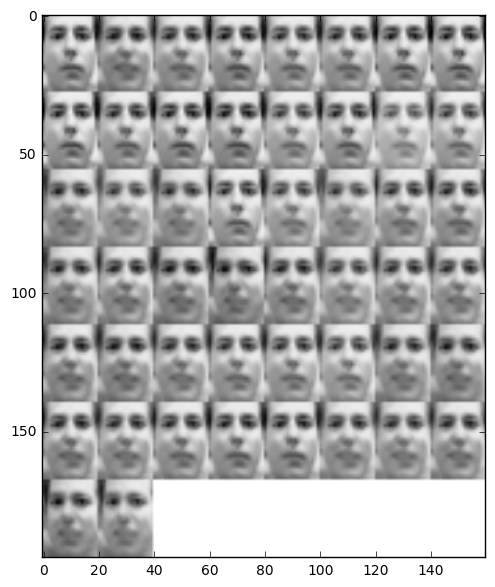

In [13]:
all_params = encoder_params + decoder_params
# You will make changes here
logpxz = (-(0.5 * np.log(2 * np.pi) + 0.5 * log_sigma2_dec) -
            0.5 * ((x - mu_dec)**2 / T.exp(log_sigma2_dec))).sum(axis=1)
KLD = -0.5 * T.sum(1 + log_sigma2_enc - mu_enc**2 - T.exp(log_sigma2_enc), axis=1)
# End of changes
logpx = T.mean(logpxz - KLD) 



x_train = faces[0:1500,:].astype('float64')
x_valid = faces[1500:,:].astype('float64')

batch_size = 100
batch_count = x_train.shape[0]//batch_size
batches = np.arange(batch_count)

updates = adam(-logpx,all_params)
likelihood = theano.function([x], logpx)
encode = theano.function([x], z)
decode = theano.function([z], mu_dec)
reconstruct = theano.function([x],mu_dec)
train = theano.function(inputs=[x],
                        outputs=logpx,
                        updates=updates)

np.random.seed(1)
for i in range(200):        
    np.random.shuffle(batches)
    for batch in batches:
        minibatch = x_train[batch*batch_size:(batch+1)*batch_size, :]
        train(minibatch)    
    if i % 50 == 0:        
        print("iter",i,"current likelihood",likelihood(x_valid))
                                   
show_examples(reconstruct(x_train[1:1500:30,:]))

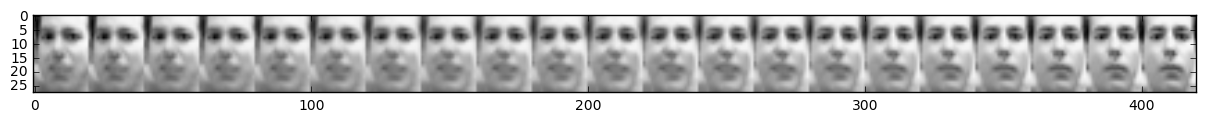

In [14]:
starting_face =  np.asmatrix(x_train[800,:])
end_face = np.asmatrix(x_train[1,:])

# Make changes to compute the start_code
# Note that we already have functions encode and decode.
# Use them

# HW changes here
start_code = encode(starting_face)
end_code = encode(end_face)
d = (end_code - start_code)/20
trace = np.zeros([21,560])
for i in np.arange(21):
    code = start_code + d*i
    trace[i,:] = decode(code)
# End of homework changes

show_examples(trace,square=False)    